### Imports

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import time
import xgboost as xgb
from xgboost import DMatrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

### Feature Engineering

In [2]:
### reading and sampling the data

def read_file(path):
    """
    reads the file in pandas df and converts the date_time column to datetime type
    """
    df = pd.read_csv(path)
    df['date_time'] = pd.to_datetime(df['date_time'])
    return df

def sample_on_srch_id(df, frac = 0.1):
    """
    samples the dataframe based on the fraction of srach_id
    """
    # get unique srch_ids
    srch_ids = np.unique(df.srch_id)
    # calculate how many ids to return
    chosen_k = int(len(srch_ids) * frac)
    # sample ids
    chosen_ids = random.sample(list(srch_ids), k = chosen_k)
    # filter the df to only have sampled ids
    return df[df['srch_id'].isin(chosen_ids)]

### Feature Engineering --------------------------

## missing data ----------------------------------

def remove_missing_values(df):
    """
    removes columns with more than 50 percent missing data
    """
    missing_values = df.isna().mean().round(4) * 100
    missing_values = pd.DataFrame(missing_values).reset_index()
    missing_values.columns = ["column", "missing"]
    # filter where there are missing values
    missing_values.query("missing > 50", inplace=True)  # remove columns with more than 50 % of missing values
    missing_values.sort_values("missing", inplace=True)
    #print(missing_values)
    df.drop(missing_values.column, axis=1, inplace=True)

def replace_missing_values(df):
    """
    imputes missing values with -1
    """
    df.fillna(value=-1, inplace=True) 

## new features ----------------------------------

def extract_time(df):
    """ 
    month, week, day of the week and hour of search
    """
    df_datetime = pd.DatetimeIndex(df.date_time)
    df["month"] = df_datetime.month
    df["week"] = df_datetime.week
    df["day"] = df_datetime.dayofweek + 1
    df["hour"] = df_datetime.hour
    del df['date_time']

def new_historical_price(df):
    """
    'unlogs' prop_log_historical_price column
    """
    df["prop_historical_price"] = (np.e ** df.prop_log_historical_price).replace(1.0, 0)
    df.drop("prop_log_historical_price", axis=1, inplace=True)

def add_price_position(df, rank_type = "dense"):
    """
    adds hotel price position ("price_position") inside "srch_id" column
    """
    ranks = df.groupby('srch_id')['price_usd'].rank(ascending=True, method = rank_type)
    df["price_position"] = ranks


def average_numerical_features(df, group_by = ["prop_id"], columns = ["prop_starrating", "prop_review_score", "prop_location_score1", "prop_location_score2"]):
    """
    adds mean, median and standard deviation per prop_id (default) 
    for columns that are related to property (default)
    """
    # caulcate means and rename columns
    means = df.groupby(group_by)[columns].mean().reset_index()
    means.columns = [means.columns[0]] + [x + "_mean" for x in means.columns[1:]]
    # caulcate median and rename columns
    medians = df.groupby(group_by)[columns].median().reset_index()
    medians.columns = [medians.columns[0]] + [x + "_median" for x in medians.columns[1:]]
    # caulcate means and rename columns
    stds = df.groupby(group_by)[columns].std().reset_index()
    stds.columns = [stds.columns[0]] + [x + "_std" for x in stds.columns[1:]]
    ## attach aggregated data to the df
    df = pd.merge(df, means, on=group_by)
    df = pd.merge(df, medians, on=group_by)
    df = pd.merge(df, stds, on=group_by)
    return df

def add_historical_booking_click(df):
    """
    creates a column with the percentage of the prop_id booked/clicked rate overall
    """
    # there are more prop_id in the test data than in train. 
    # Maybe we could still use this but would need to impute
    # with the most common value (or something else)
    
    historical = df.groupby("prop_id")[["click_bool", "booking_bool"]].mean().reset_index()
    historical.columns = [historical.columns[0]] + [x + "_rate" for x in historical.columns[1:]]
    df = pd.merge(df, historical, on="prop_id")
    df.sort_values("srch_id", inplace = True)
    return df

def join_historical_data(df, path = "hist_click_book.csv"):
    """
    joins historical data according to prop_id. 
    path - location of historical data csv file
    
    """
    to_join = pd.read_csv(path)
    joined = pd.merge(df, to_join, on="prop_id")
    return joined.sort_values("srch_id")
    
    
## other ----------------------------------

def remove_cols(df, cols = ["position", "prop_id"]):
    df.drop(cols, axis=1, inplace=True)

def remove_positions(df, positions = [5, 11, 17, 23]):
    """
    removes hotels with specified positions 
    (based on the fact that hotels in those positions were not as booked)
    """
    df = df[df["position"].isin(positions) == False]

def add_score(df):
    
    """
    adds 'score' column to the df: 5 for booked, 1 for clicked
    """
    
    score = []
    for book, click in zip(df.booking_bool, df.click_bool):
        if book == 1:
            score.append(5)
            continue
        if click == 1:
            score.append(1)
            continue
        else:
            score.append(0)
    df["score"] = score
    del df['booking_bool']
    del df['click_bool']

def onehot(df, cols):
    """ 
    returns a df with one-hot encoded columns (cols)
    """
    
    return pd.get_dummies(df, columns=cols)

def sampling(df, target, method="undersampling", frac=0.3):
    
    """
    df: input dataframe
    targetcol: target column of majority class
    method: specifies method of sampling - 'undersampling' or 'combination' of undersampling and oversampling.
    frac: final fraction minority wrt majority class (default fraction 0.15/0.85)
    
    returns: df with undersampled majority and oversampled minority class
    
    note that this only has to be performed on the training data!
    
    """
    
    # Split df in minority and majority
    minority = df.loc[df[target] > 0]
    majority = df.loc[df[target] == 0]
    lenmin = len(minority)
    lenmaj = len(majority)
    
    # Calculate current fraction
    frac_min = lenmin/(lenmin+lenmaj)
    frac_maj = 1-frac_min
    print(f"Current fraction:\nMinority class: {frac_min}, Majority class: {frac_maj}")
    
    if method == "undersampling":
        
        sampling_frac = ((1-frac)/frac*lenmin)/lenmaj
        sampled_df = df.groupby('srch_id').sample(frac=sampling_frac)
        fin_frac = lenmin / (len(sampled_df) + lenmin)

    elif method == "combination":
        
        # This still needs to be implemented
        
        return
    else:
        raise ExceptionError("Invalid argument for 'method'")
        
    
    print(f"Final fraction:\nMinority class: {fin_frac}, Majority class: {1-fin_frac}")
    
    dfs = [minority, sampled_df]
    finaldf = pd.concat(dfs)
    finaldf.sort_values("srch_id", inplace = True)
    finaldf = finaldf.reset_index(drop=True)

    print("Done")
    return finaldf


### Feature engineering function -----------

def feature_engineering_train(df):
    
    extract_time(df)
    remove_missing_values(df)
    replace_missing_values(df)
    new_historical_price(df)
    add_price_position(df)
#     df = average_numerical_features(df)
#     df = add_historical_booking_click(df)
    add_score(df)
    #remove_cols(df)
    return df

def feature_engineering_test(df):
    
    extract_time(df)
    remove_missing_values(df)
    replace_missing_values(df)
    new_historical_price(df)
    add_price_position(df)
#     df = average_numerical_features(df)
#     df = join_historical_data(df, path="data/hist_click_book.csv")
    return df
    
def create_df_queries_freq(df):
    df_queries = pd.DataFrame()
    df_queries = pd.crosstab(index=df['srch_id'], columns='count', colnames=['srch_id'])
    df_queries.head()
    df_queries.to_csv("../df_queries.csv")
    return pd.read_csv("../df_queries.csv")

In [3]:
df = pd.read_csv("data/training_set_VU_DM.csv")
# testset = pd.read_csv("data/test_set_VU_DM.csv")

In [4]:
# perform the feature engineering on the training data

df = feature_engineering_train(df)

<ipython-input-2-987ae63e5a1e>:55: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["week"] = df_datetime.week


In [5]:
# check if everything is valid
df.head()

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,...,srch_saturday_night_bool,orig_destination_distance,random_bool,month,week,day,hour,prop_historical_price,price_position,score
0,1,12,187,219,893,3,3.5,1,2.83,0.0438,...,1,-1.0,1,4,14,4,8,141.174964,3.0,0
1,1,12,187,219,10404,4,4.0,1,2.20,0.0149,...,1,-1.0,1,4,14,4,8,152.933013,14.0,0
2,1,12,187,219,21315,3,4.5,1,2.20,0.0245,...,1,-1.0,1,4,14,4,8,137.002613,15.0,0
3,1,12,187,219,27348,2,4.0,1,2.83,0.0125,...,1,-1.0,1,4,14,4,8,80.640419,22.0,0
4,1,12,187,219,29604,4,3.5,1,2.64,0.1241,...,1,-1.0,1,4,14,4,8,138.379512,11.0,0


#### Categorical, Important and Numerical Features

In [6]:
rf_features = ['site_id', 'visitor_location_country_id', 'prop_country_id', 'day', 'hour', 'price_position', 
               'prop_starrating', 'price_usd', 'prop_historical_price', 'booking_bool_rate', 'click_bool_rate', 
               'srch_booking_window', 'week', 'month']

### Random Forest settings

In [7]:
# SET RF TRUE IF YOU WANT TO INCLUDE RANDOM FOREST 
# Useful for dealing with specifically categorical variables
# Weight of RF model
# True takes longer, but for experimenting its nice

RF = "False"
weight = 1

### Train - test split

In [8]:
# Only useful for experimenting
# Take a sample of 50 percent of all data

subsample = 1

df = sample_on_srch_id(df, frac = subsample)
del df['position']

# split sample in training- and test set by srch_id
gss = GroupShuffleSplit(test_size=.52, n_splits=1, random_state = 7).split(df, groups=df['srch_id'])

X_train_inds, X_test_inds = next(gss)

In [9]:
train_data= df.iloc[X_train_inds]

# X_train and categorical X_train
X_train = train_data.loc[:, ~train_data.columns.isin(['srch_id','score'])]

if RF == "True":
#     c_X_train = X_train[rf_features]
    c_X_train = X_train.copy()

y_train = train_data.loc[:, train_data.columns.isin(['score'])]

if RF == "True":
    # replace 5 by 1 to make it binary classification
#     c_y_train = pd.DataFrame()
#     c_y_train['score'] = y_train['score'].replace(5, 1)
    c_y_train = y_train.copy()

del X_train['prop_id']

groups = train_data.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

test_data = df.iloc[X_test_inds]

# X_test and categorical X_test
X_test = test_data.loc[:, ~test_data.columns.isin(['score'])]

if RF == "True":
#     c_X_test = X_test[rf_features]
    c_X_test = X_test.copy()
    del c_X_test["srch_id"]

y_test = test_data.loc[:, test_data.columns.isin(['score'])]

if RF == "True":
    # replace 5 by 1 to make it binary classification
#     c_y_test = pd.DataFrame()
#     c_y_test['score'] = y_test['score'].replace(5, 1)
    c_y_test = y_test.copy()

# delete prop_id
test_properties = X_test["prop_id"].copy()
del X_test['prop_id']

### RandomForest Model

Random Forest is known to take categorical features into account, therefore use a small model to train a model where the categorical values come to good right. This is not proper english I know.

In [10]:
# Using sklearn RandomForest Package

if RF == "True":
    clf = RandomForestClassifier(n_estimators=45)
    clf.fit(c_X_train, c_y_train)
    y_pred_bool = clf.predict(c_X_test)
    
    # Crosstable (FP, TP, FN, TN)
    print(pd.crosstab(np.array(c_y_test).reshape(len(c_y_test,)), y_pred_bool))
    
    # Predict Probabilities with RF
    y_pred = clf.predict_proba(c_X_test)

    # Predicted probabilities
    pp = [item[1] for item in y_pred]

### XGboost: LambdaMART Pairwise Ranking

In [11]:
model = xgb.XGBRanker(  
    tree_method='hist',
    booster='gbtree',
    objective='rank:ndcg',
    random_state=42, 
    learning_rate=0.05,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=1000, 
    subsample=0.75,
    )

model.fit(X_train, y_train, group=groups, verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.9, eta=0.05, gamma=0,
          gpu_id=-1, importance_type='gain', interaction_constraints='',
          learning_rate=0.05, max_delta_step=0, max_depth=6, min_child_weight=1,
          missing=nan, monotone_constraints='()', n_estimators=1000, n_jobs=8,
          num_parallel_tree=1, objective='rank:ndcg', random_state=42,
          reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.75,
          tree_method='hist', validate_parameters=1, verbosity=None)

In [12]:
def predict(model, df):
    return model.predict(df.loc[:, ~df.columns.isin(['srch_id'])])

In [13]:
# this is not necessary right?

del test_data['score']

In [14]:
predictions = (X_test.groupby('srch_id')
               .apply(lambda x: predict(model, x)))

In [15]:
predictions

srch_id
6         [-2.1822188, -1.4270487, -1.0768486, -0.853623...
8         [0.73587203, 0.26955682, -0.24831572, 1.442888...
12        [0.22477828, -1.7980449, -0.42181233, -0.92694...
17        [-0.36366293, 0.8290106, -1.6043519, -0.568405...
25        [-1.1136748, -2.027256, 2.3501399, 1.1654656, ...
                                ...                        
332777    [-0.82907134, 0.075486615, 0.39725268, -0.0622...
332781    [-2.401985, 2.0153272, -1.136591, -2.461943, -...
332782    [1.6181043, -0.3056819, -2.335187, -0.38341787...
332784    [-0.025300734, 0.6763942, -0.42598388, 0.41297...
332785    [-1.3734628, 0.38904926, 1.6814212, -0.1661467...
Length: 103894, dtype: object

#### Most important features for the xgboost LambdaMART model

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

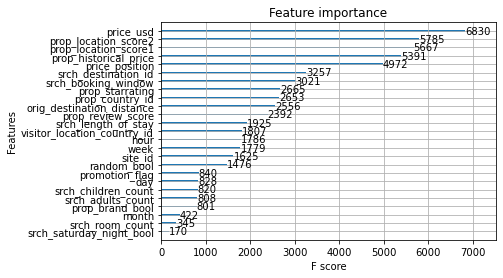

In [16]:
xgb.plot_importance(model)

### Composite RF and LambdaMART score

In [17]:
output = pd.DataFrame()
output["srch_id"] = test_data["srch_id"].copy()
output["prop_id"] = test_properties.copy()

# Add scores
pred_scores_list = []

for i in predictions:
    for j in i:
        pred_scores_list.append(j)
        

if RF == "True":
    output["pred_scores"] = [x + weight*y for x, y in zip(pred_scores_list, pp)]
else:
    output["pred_scores"] = pred_scores_list


In [18]:
# Sort on predicted_score output within srch_id

out = output.groupby('srch_id').apply(pd.DataFrame.sort_values, 'pred_scores', ascending=False)
del out["pred_scores"]

### Evaluation

In [19]:
def NDCG(predictions, df, path_idcg = "idcg.csv"):
    """
    takes predicted positions and calulates average ndcg.
    predictions - dataframe must have "srch_id" and "prop_id" ordered by relevance (inside "srch_id") (basically Lotte's model "out" dataframe)
    df - training dataset (must contain "srch_id", "prop_id", "score")
    path_idcg - path to idcg scores per "srch_id"
    """
    # reset index 
    predictions.reset_index(drop = True, inplace = True)
    # add position + 1
    predictions["position"] = predictions.groupby(by = ['srch_id']).cumcount()+1
    # filter to only have positions up to 5
    predictions = predictions[predictions.position < 6]
    # attach scores to predictions
    predictions = pd.merge(predictions, df[["srch_id", "prop_id", "score"]], on = ["srch_id", "prop_id"])
    predictions["numerator"] = predictions["score"]
    predictions["denominator"] = np.log2(predictions["position"])
    predictions.loc[predictions.position == 1, "denominator"] = 1
    predictions["intermediate_dcg"] = predictions["numerator"]/predictions["denominator"]
    dcg = predictions.groupby("srch_id")["intermediate_dcg"].sum().reset_index()
    dcg.columns = ["scrh_id", "DCG"]
    # read idcg
    idcg = pd.read_csv(path_idcg)
    # attach idcg to dcg
    joined = pd.merge(dcg, idcg, on = "scrh_id")
    # calculate NDCG
    joined["NDCG"] = joined["DCG"]/joined["iDCG"]
    # calculate mean NDCG
    return joined["NDCG"].mean()

In [20]:
# Create reduced testdf for input in ndcg

reduced_df = X_test.filter(['srch_id'], axis=1)
reduced_df["prop_id"] = test_properties
reduced_df["score"] = y_test

In [21]:
scores = NDCG(out, reduced_df, path_idcg = "idcg.csv")
scores

0.44186973199325597

#### Experiment: Does RF contribute?

In [22]:
raise NotImplementedError("Stop")

NotImplementedError: Stop

In [ ]:
# Run this if you want to see whether the RF model actually contributes
# with rf_features, higherst is rf model_weight 0.05, ndcg = 1 , score of 0.54307
# with all features for RF: highest: ndcg_weight: , rf model weight:
# the above is also with a continous output

weights = [0, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2]
weights_ndcg = [1, 0.75, 0.5, 0.25]
scores = []

# if KeyError about pred_scores, uncomment following line
# output["pred_scores"] = pred_scores_list

for i in weights:
    for j in weights_ndcg:
        if i == 0 and j in [1, 0.75, 0.5, 0.25]:
            continue
        del output["pred_scores"]
        output["pred_scores"] = [j*x + i*y for x, y in zip(pred_scores_list, pp)]
        out = output.groupby('srch_id').apply(pd.DataFrame.sort_values, 'pred_scores', ascending=False)
        del out["pred_scores"]
        temp = NDCG(out, reduced_df, path_idcg = 'idcg.csv')
        print(f"NDCG weight: {j}, RF weight: {i}, NDGC:{temp}")
        scores.append([(j,i),temp])

In [ ]:
del output["pred_scores"]
output["pred_scores"] = [x + 3*y for x, y in zip(pred_scores_list, pp)]
out = output.groupby('srch_id').apply(pd.DataFrame.sort_values, 'pred_scores', ascending=False)
del out["pred_scores"]
temp = NDCG(out, reduced_df, path_idcg = 'idcg.csv')
print(f"NDCG weight: {j}, RF weight: {i}, NDGC:{temp}")
scores.append([(j,i),temp])

In [ ]:
del output["pred_scores"]
output["pred_scores"] = [x + 4*y for x, y in zip(pred_scores_list, pp)]
out = output.groupby('srch_id').apply(pd.DataFrame.sort_values, 'pred_scores', ascending=False)
del out["pred_scores"]
temp = NDCG(out, reduced_df, path_idcg = 'idcg.csv')
print(f"NDCG weight: {j}, RF weight: {i}, NDGC:{temp}")
scores.append([(j,i),temp])

In [ ]:
scores.append([(j,i),temp])
del output["pred_scores"]
output["pred_scores"] = [x + 5*y for x, y in zip(pred_scores_list, pp)]
out = output.groupby('srch_id').apply(pd.DataFrame.sort_values, 'pred_scores', ascending=False)
del out["pred_scores"]
temp = NDCG(out, reduced_df, path_idcg = 'idcg.csv')
print(f"NDCG weight: {j}, RF weight: {i}, NDGC:{temp}")
scores.append([(j,i),temp])

In [ ]:
scores.append([(j,i),temp])
del output["pred_scores"]
output["pred_scores"] = [0*x + 1*y for x, y in zip(pred_scores_list, pp)]
out = output.groupby('srch_id').apply(pd.DataFrame.sort_values, 'pred_scores', ascending=False)
del out["pred_scores"]
temp = NDCG(out, reduced_df, path_idcg = 'idcg.csv')
print(f"NDCG weight: {j}, RF weight: {i}, NDGC:{temp}")
scores.append([(j,i),temp])

In [ ]:
# Print maximum score and parameters for models
max_score = 0
score_index = 0

for k,l in enumerate(scores):
    if l[1] < max_score:
        continue
        
    max_score = l[1]
    score_index = k

# format: [(xgboost, RF), ndcg]
print(f"Best combination: {scores[score_index]}")